In [36]:
import numpy as np
import emcee
import pandas as pd

import time
from multiprocessing import Pool

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

To understand the effects of telescope aperture (or limiting mag) on one's ability to recover the time of explosion (or better, the time of first light for a young SN), we construct a simple generative model to simulate the flux from the SN. 

$$ \begin{align} f_\mathrm{SN}(t) & = 0, & \mathrm{when}\; t \le t_\mathrm{exp} \\ & \propto (t-t_\mathrm{exp})^{\alpha}, & \mathrm{when}\; t > t_\mathrm{exp} \end{align}. $$

Where $t$ is time, $t_\mathrm{exp}$ is the time of SN explosion, and $\alpha$ is the power-law index of the initial rise.

To account for the noise in the telescope system, a systematic contribution is added to the SN flux, where the magnitude of the systematic term is related to the limiting magnitude of the telescope. For example, when we adopt:
$$ m = 25 - 2.5\log(\mathrm{counts}),$$
for a $m = 20\,\mathrm{mag}$ $5\sigma$ limit, the counts = 100 and therefore `sigma_sys` = 20.

Using this generative model, we can incorporate the effects of a detection limit via the `sigma_sys` variable. In particular, smaller aperture telescopes will have larger values of sigma_sys as follows:

 

| $m_\mathrm{lim}$ | counts | `sigma_sys` |
|   ----           |   ---- |     ----    |
|   21.5           |   25.1 |     5.02    |
|   21.0           |   39.8 |     7.96    |
|   20.0           |  100.0 |    20.00    |
|   19.0           |  251.2 |    50.23    |
|   18.0           |  631.0 |   126.19    |
|   17.0           | 1584.9 |   316.98    |
|   16.0           | 3981.1 |   796.21    |

In [2]:
def gen_data(times, baseline=0, t_exp=0, alpha=2, 
             amplitude=25, sigma_sys=5):
    '''
    Generate a simple SN Ia-like light curve
    
    Parameters
    ----------
    
    times : array-like
        The times at which the simulated data should be generated.
        Times are in units of days.
    
    baseline : float, optional (default=0)
        The baseline value for the flux of the transient in the 
        telescope system.
    
    t_exp : float, optional (default=0)
        The time of explosion for the SN.
    
    alpha : float, optional (default=2)
        Power-law index for the initial rise of the SN.
    
    amplitude : float, optional (default=25)
        Normalizing amplitude for rise of the SN, the default value
        is determined by assuming an alpha=2 increase in flux, 
        m_peak = 15 mag, and a 20 d rise time for the SN.
    
    sigma_sys : float, optional (default=5)
        The systematic noise present in the light curves due to 
        the telescope system. The default value is determined from 
        assuming a telescope limiting magnitude of 21.5.
    
    Returns
    -------
    cnts : array-like, shape=shape(times)
        The counts corresponding to the SN flux, after taking into 
        account the noise associated with the detector
    
    cnts_unc : array-like, shape=shape(times)
        Uncertainty in the number of counts from the SN
    '''
    
    cnts = np.zeros_like(times)
    cnts_unc = np.zeros_like(times)

    pre_explosion = np.logical_not(times > t_exp)
    cnts[pre_explosion] = np.random.normal(baseline, sigma_sys, size=sum(pre_explosion))
    cnts_unc[pre_explosion] = np.ones_like(times)[pre_explosion]*sigma_sys

    sn_flux = amplitude*(times[~pre_explosion] - t_exp)**alpha
    sn_with_random_noise = sn_flux + np.random.normal(np.zeros_like(sn_flux), np.sqrt(sn_flux))
    sn_with_random_plus_sys = sn_with_random_noise + np.random.normal(baseline, sigma_sys, size=len(sn_flux))

    # total uncertainty = systematic + Poisson
    sn_uncertainties = np.hypot(np.sqrt(np.maximum(sn_with_random_noise, np.zeros_like(sn_with_random_noise))), 
                                sigma_sys)

    cnts[~pre_explosion] = sn_with_random_plus_sys
    cnts_unc[~pre_explosion] = sn_uncertainties

    return cnts, cnts_unc

Example light curves for a telescope with $m_\mathrm{lim} \approx 20\,\mathrm{mag}$ and $m_\mathrm{lim} \approx 17\,\mathrm{mag}$ are shown below. It's clear that the inferred parameters, and $t_0$ in particular are going to be very different for the two telescopes. 

<IPython.core.display.Javascript object>


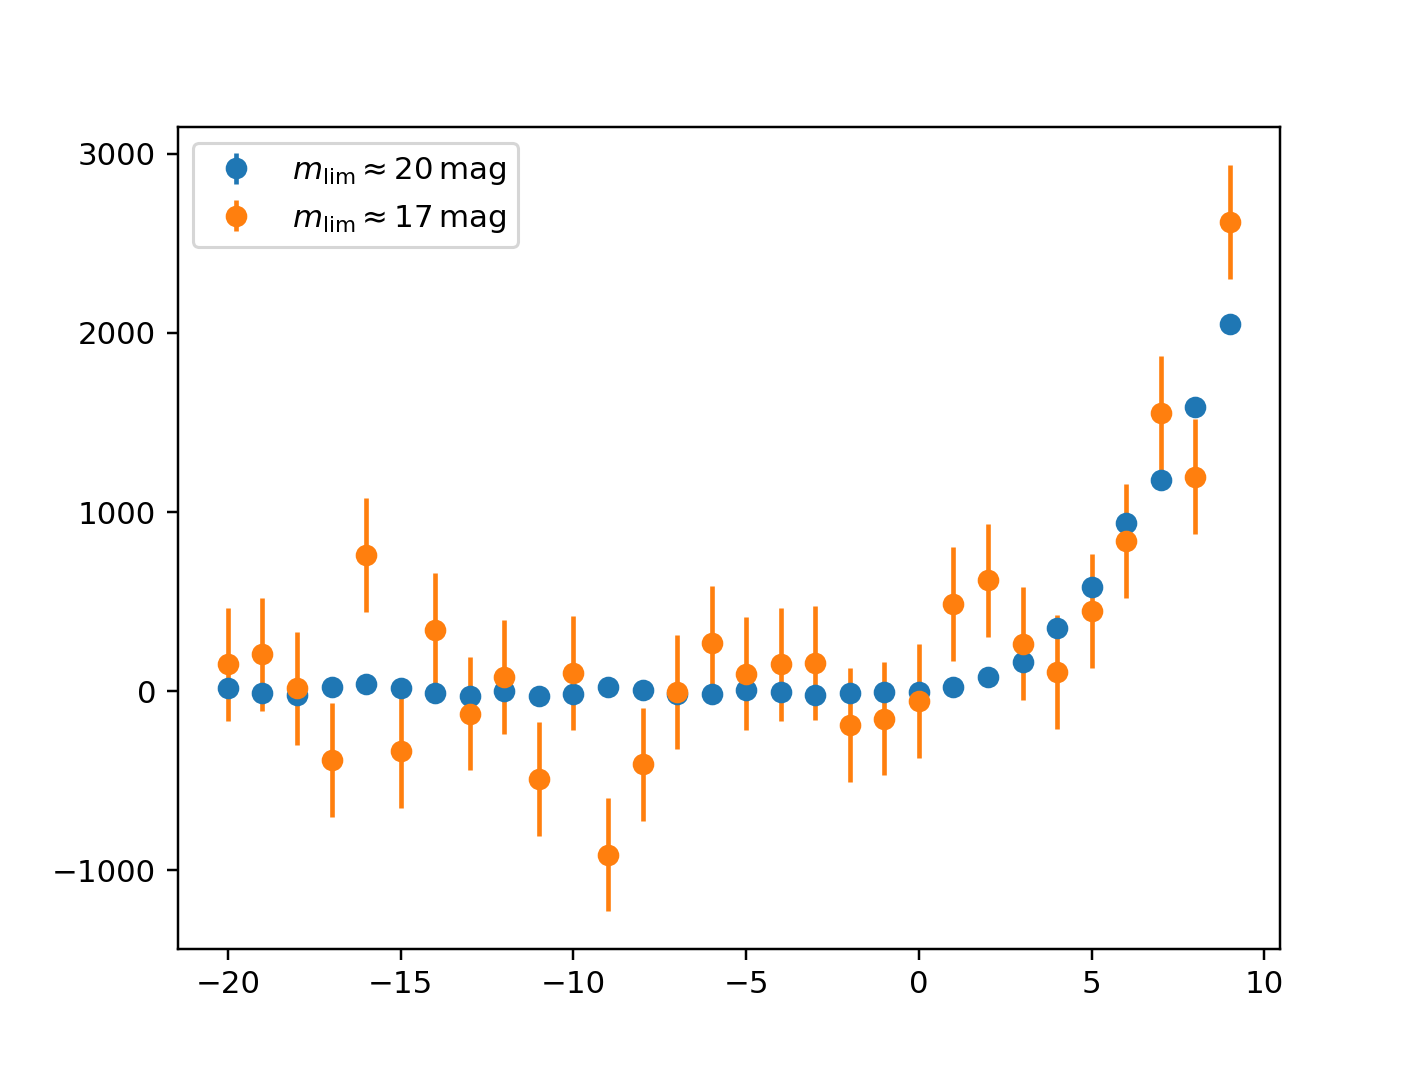

In [4]:
for label, sigma_sys in zip([r"$m_\mathrm{lim} \approx 20\,\mathrm{mag}$", 
                             r"$m_\mathrm{lim} \approx 17\,\mathrm{mag}$"], 
                            [20, 317]):
    times = np.arange(-20,10, dtype=float)
    cnts, cnts_unc = gen_data(times, sigma_sys=sigma_sys)
    plt.errorbar(times, cnts, cnts_unc, fmt='o', 
                 label=label)
    plt.legend()            

We now wish to model the simulated light curves using our new Bayesian framework.

In [3]:
#Define the log likelihood
def lnlikelihood(theta, f, t, f_err):
    a, b, t_0, alpha, sig_0 = theta

    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    model[~pre_exp] = a + (b*((t[~pre_exp] - t_0)**alpha))
    ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err**2))) - ((f - model)**2 / (2 * (sig_0**2 + f_err**2))))
    return ln_l

#Define priors on parameters  
def lnprior(theta):
    a, b, t_0, alpha, sig_0 = theta
    if (-100 < t_0 < 100 and 0 < alpha < 100 and 0 < sig_0 < 10000 and -1000 < a < 1000 and  0 < b < 1e5):
        return 0.0
    return -np.inf
   
def lnposterior(theta, f, t, f_err):
    lnp = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp 

In [6]:
# setup various emcee parameters

#initial guess on parameters
guess_0 = [0, 10, 0, 2, 10]

#number of walkers
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess_0)
ncores=4

#initial position of walkers
pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

# light curve to fit
det = np.where(cnts/cnts_unc >= 4)
t_data = t_obs[:det[0][0]+3]
f_data = cnts[:det[0][0]+3]
f_unc_data = cnts_unc[:det[0][0]+3]

#run initial burn-in
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
nsamples = 5000
foo = sampler.run_mcmc(pos, nsamples)

# run second burn in
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[:,-1])]
pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
nsamples = 5000
foo = sampler.run_mcmc(pos, nsamples)

In [7]:
# set a "burn-in" limit
nburn = 3000

#Grab alpha and t_0 samples from all walkers
alpha_samples = np.array(sampler.chain[:,:nburn,3]).flatten()
t_0_samples = np.array(sampler.chain[:,:nburn,2]).flatten()
a_samples = np.array(sampler.chain[:,:nburn,0]).flatten()
sig_0_samples = np.array(sampler.chain[:,:nburn,4]).flatten()
b_samples = np.array(sampler.chain[:,:nburn,1]).flatten()
#print the median taking 1-sigma confidence intervals
samples = np.vstack([t_0_samples, alpha_samples, a_samples, b_samples, sig_0_samples]).T

In [17]:
flat_samples = sampler.flatchain?

In [ ]:
flat_samples = sampler.flatchain

In [16]:
np.shape(flat_samples)

(500000, 5)

In [8]:
t_0_mc, alpha_mc, a_mc, b_mc, sig_0_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                             zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))
print("emcee results with 68% credible regions\n \
      t_0 = {:.4f} -{:.4f} +{:.4f}\n \
      alpha = {:.4f} -{:.4f} +{:.4f}\n \
      a = {:.4f} -{:.4f} +{:.4f}\n \
      b = {:.4f} -{:.4f} +{:.4f}\n \
      sig_0 = {:.4f} -{:.4f} +{:.4f}\n" \
      .format(t_0_mc[2], t_0_mc[2] - t_0_mc[1], t_0_mc[3] - t_0_mc[2], 
              alpha_mc[2], alpha_mc[2] - alpha_mc[1], alpha_mc[3] - alpha_mc[2], 
              a_mc[2], a_mc[2] - a_mc[1], a_mc[3] - a_mc[2],
              b_mc[2], b_mc[2] - b_mc[1], b_mc[3] - b_mc[2],
              sig_0_mc[2], sig_0_mc[2] - sig_0_mc[1], sig_0_mc[3] - sig_0_mc[2]))

emcee results with 68% credible regions
       t_0 = 3.2557 -0.7864 +0.6714
       alpha = 0.7351 -0.2796 +0.3324
       a = -47.9198 -45.7641 +48.5970
       b = 610.9544 -292.6136 +377.4856
       sig_0 = 88.1665 -63.7462 +78.7637



In [9]:
sampler.chain?

In [8]:
t_0_res = np.zeros((100, 5))

t_0_res[0] = t_0_mc

<IPython.core.display.Javascript object>


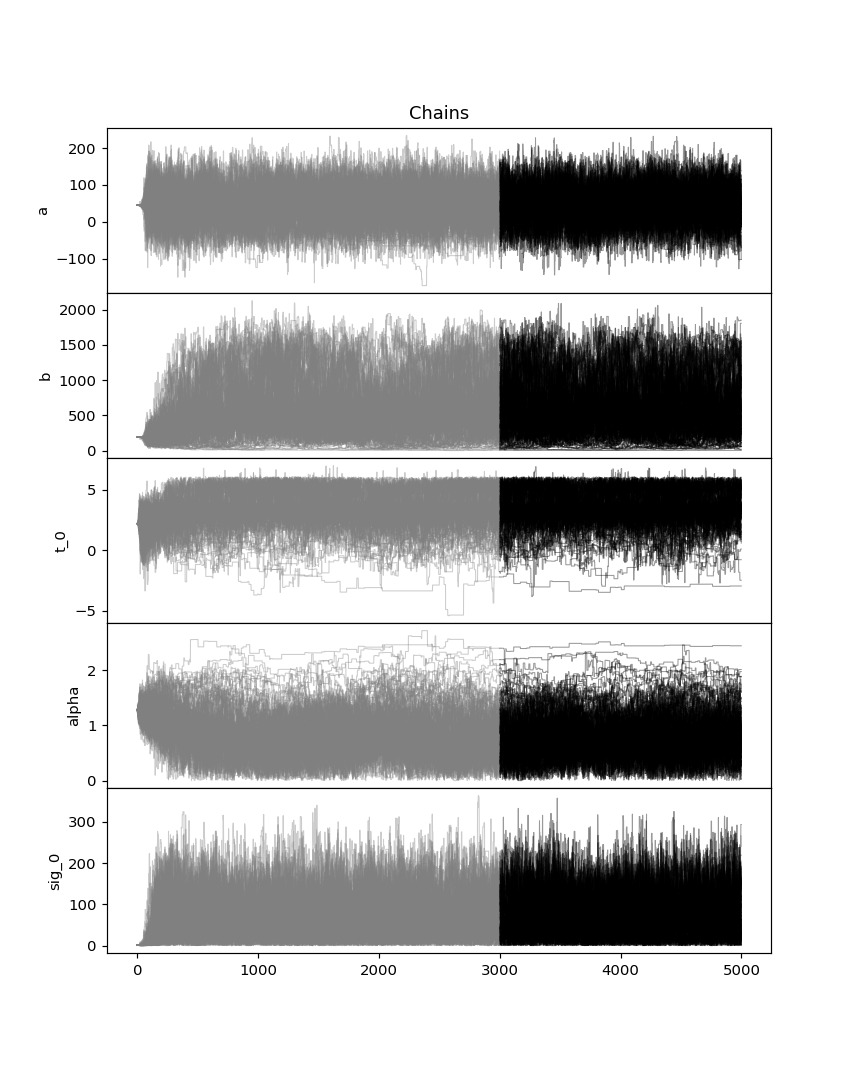

In [19]:
ax = plotChains(sampler, nburn, paramsNames)
plt.show()

<IPython.core.display.Javascript object>


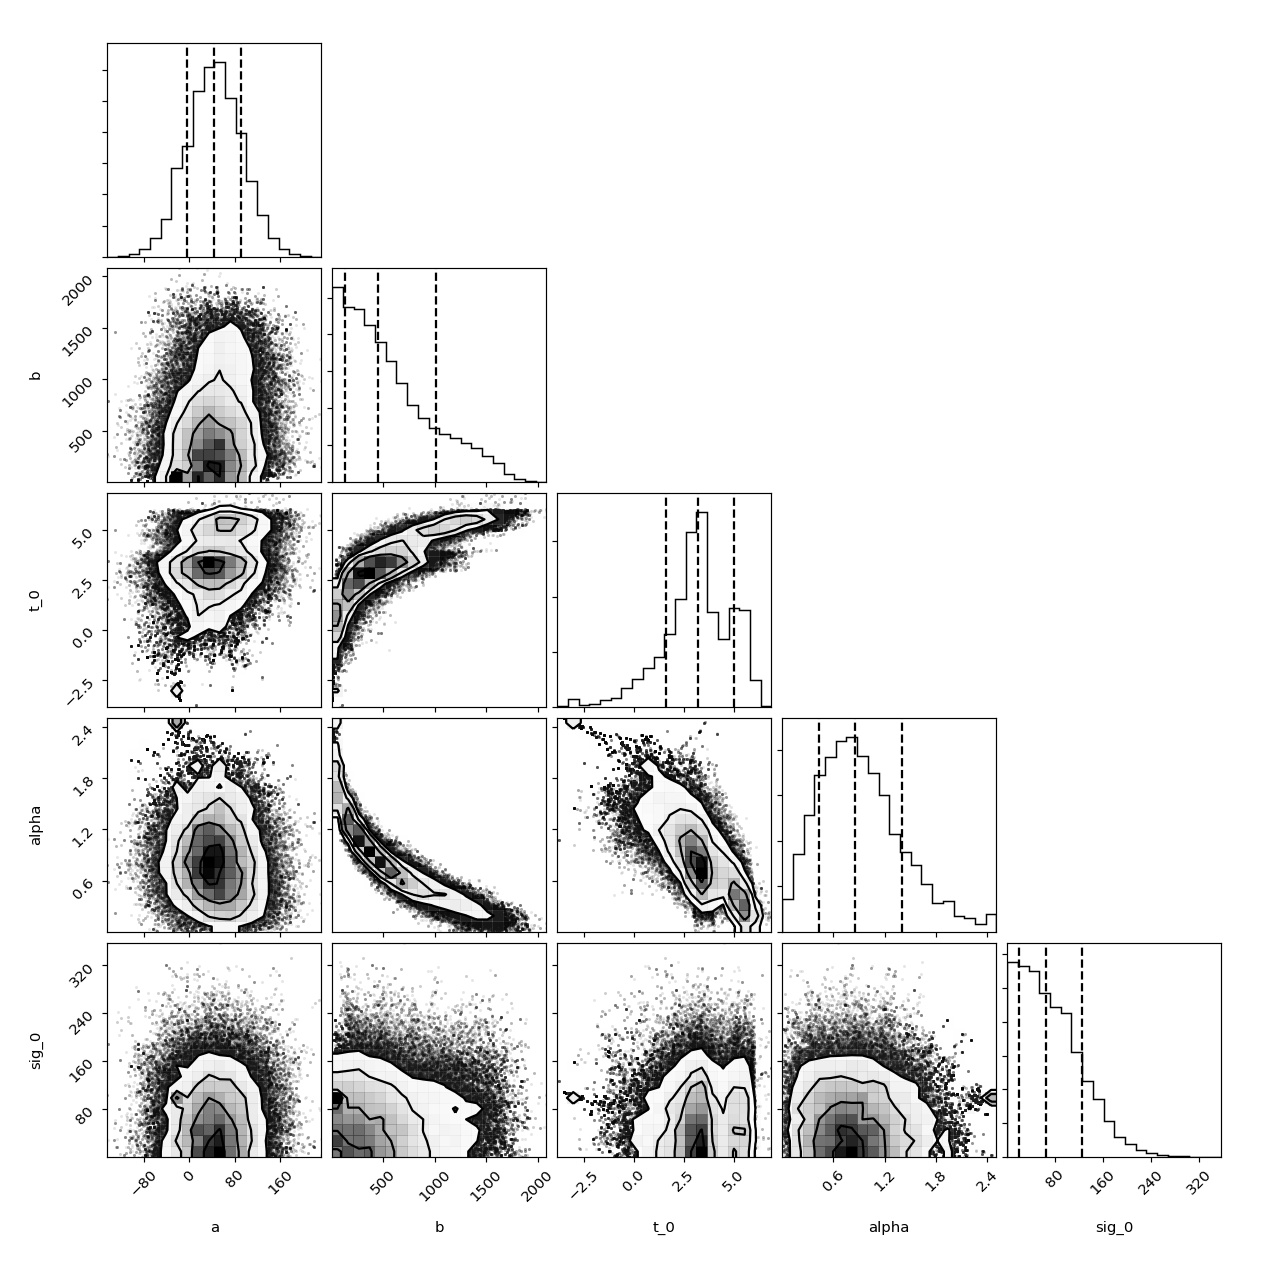

In [20]:
makeCorner(sampler, nburn, paramsNames)
plt.show()

Now we will create the loop to measure how well telescopes with different limiting magnitudes perform.

In [7]:
n_loop = 100
tel_noise = 8

t_start = time.time()
t_det_res = np.zeros(n_loop)
t_0_res = np.zeros((n_loop, 5))
alpha_res = np.zeros((n_loop, 5))
sig_0_res = np.zeros((n_loop, 5))
a_res = np.zeros((n_loop, 5))
b_res = np.zeros((n_loop, 5))

for loop_num in range(n_loop):
    #Simulate ith light curve
    t_obs = np.arange(-45,10, dtype=float) + np.random.uniform(-1/24,1/24,size=55) + np.random.uniform()
    cnts, cnts_unc = gen_data(t_obs, sigma_sys=tel_noise)

    # light curve to fit
    det = np.where(cnts/cnts_unc >= 4)
    t_data = t_obs[:det[0][0]+4]
    f_data = cnts[:det[0][0]+4]
    f_unc_data = cnts_unc[:det[0][0]+4]

    
    # run MCMC
    #initial guess on parameters
    guess_0 = [0, 10, 0, 2, 10]

    #number of walkers
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=4

    #initial position of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

    #run initial burn-in
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
    nsamples = 2500
    sampler.run_mcmc(pos, nsamples);

    # run second burn in
    burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
    pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    
    # intermediate file to write out data
    filename = "noise{}_loop{}.h5".format(tel_noise, loop_num)
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)

    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), backend=backend)
    nsamples = 5000
    sampler.run_mcmc(pos, nsamples, progress=True);

    # set a "burn-in" limit
    nburn = 3000

    #Grab alpha and t_0 samples from all walkers
    alpha_samples = np.array(sampler.chain[:,:nburn,3]).flatten()
    t_0_samples = np.array(sampler.chain[:,:nburn,2]).flatten()
    a_samples = np.array(sampler.chain[:,:nburn,0]).flatten()
    sig_0_samples = np.array(sampler.chain[:,:nburn,4]).flatten()
    b_samples = np.array(sampler.chain[:,:nburn,1]).flatten()
    #print the median taking 1-sigma confidence intervals
    samples = np.vstack([t_0_samples, alpha_samples, a_samples, b_samples, sig_0_samples]).T
    
    t_0_mc, alpha_mc, a_mc, b_mc, sig_0_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                             zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))


    t_det_res[loop_num] = t_obs[det[0][0]]
    t_0_res[loop_num] = t_0_mc
    alpha_res[loop_num] = alpha_mc
    sig_0_res[loop_num] = sig_0_mc
    a_res[loop_num] = a_mc
    b_res[loop_num] = b_mc
    
t_end = time.time()
print("Serial took {} sec".format(t_end-t_start))

100%|██████████| 5000/5000 [00:51<00:00, 93.86it/s] 


Serial took 6360.649880170822 sec


In [12]:
print('\multirow{3}{*}{$\sigma_\mathrm{back} = 8$}' + ' & $t_\mathrm{{{}}}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & $\ldots$ & $\ldots$ \\\\'.format('det', np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 86) - np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 50) - np.percentile(t_det_res, 18)
                                                  ))

for var, input_val in zip(['t_0', 'alpha', 'a', 'b', 'sig_0'], [0, 2, 0, 25, tel_noise]):
    exec(f'res = {var}_res')
    print(' & ${}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & {} & {} \\\\'.format(var, np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 86) - np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 50) - np.percentile(res[:,2], 18),
                                                   len(np.where((res[:,1] < input_val) & (res[:,3] > input_val))[0]),
                                                   len(np.where((res[:,0] < input_val) & (res[:,4] > input_val))[0])
                                                  ))

\multirow{3}{*}{$\sigma_\mathrm{back} = 8$} & $t_\mathrm{det}$ & $1.72\pm^{0.45}_{0.28}$ & $\ldots$ & $\ldots$ \\
 & $t_0$ & $0.11\pm^{0.41}_{0.33}$ & 68 & 93 \\
 & $alpha$ & $1.90\pm^{0.39}_{0.29}$ & 64 & 95 \\
 & $a$ & $-0.14\pm^{1.09}_{1.44}$ & 68 & 96 \\
 & $b$ & $30.90\pm^{24.88}_{13.63}$ & 62 & 93 \\
 & $sig_0$ & $2.33\pm^{1.13}_{0.79}$ & 0 & 9 \\


In [4]:
n_loop = 100
tel_noise = 50

t_start = time.time()
t_det_res = np.zeros(n_loop)
t_0_res = np.zeros((n_loop, 5))
alpha_res = np.zeros((n_loop, 5))
sig_0_res = np.zeros((n_loop, 5))
a_res = np.zeros((n_loop, 5))
b_res = np.zeros((n_loop, 5))

for loop_num in range(n_loop):
    #Simulate ith light curve
    t_obs = np.arange(-45,10, dtype=float) + np.random.uniform(-1/24,1/24,size=55) + np.random.uniform()
    cnts, cnts_unc = gen_data(t_obs, sigma_sys=tel_noise)

    # light curve to fit
    det = np.where(cnts/cnts_unc >= 4)
    t_data = t_obs[:det[0][0]+4]
    f_data = cnts[:det[0][0]+4]
    f_unc_data = cnts_unc[:det[0][0]+4]

    
    # run MCMC
    #initial guess on parameters
    guess_0 = [0, 10, 0, 2, 10]

    #number of walkers
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=4

    #initial position of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

    #run initial burn-in
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
    nsamples = 2500
    sampler.run_mcmc(pos, nsamples);

    # run second burn in
    burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
    pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    
    # intermediate file to write out data
    filename = "noise{}_loop{}.h5".format(tel_noise, loop_num)
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)

    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), backend=backend)
    nsamples = 5000
    sampler.run_mcmc(pos, nsamples, progress=True);

    # set a "burn-in" limit
    nburn = 3000

    #Grab alpha and t_0 samples from all walkers
    alpha_samples = np.array(sampler.chain[:,:nburn,3]).flatten()
    t_0_samples = np.array(sampler.chain[:,:nburn,2]).flatten()
    a_samples = np.array(sampler.chain[:,:nburn,0]).flatten()
    sig_0_samples = np.array(sampler.chain[:,:nburn,4]).flatten()
    b_samples = np.array(sampler.chain[:,:nburn,1]).flatten()
    #print the median taking 1-sigma confidence intervals
    samples = np.vstack([t_0_samples, alpha_samples, a_samples, b_samples, sig_0_samples]).T
    
    t_0_mc, alpha_mc, a_mc, b_mc, sig_0_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                             zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))


    t_det_res[loop_num] = t_obs[det[0][0]]
    t_0_res[loop_num] = t_0_mc
    alpha_res[loop_num] = alpha_mc
    sig_0_res[loop_num] = sig_0_mc
    a_res[loop_num] = a_mc
    b_res[loop_num] = b_mc
    
t_end = time.time()
print("Serial took {} sec".format(t_end-t_start))

print('\multirow{3}{*}{$\sigma_\mathrm{back} = 8$}' + ' & $t_\mathrm{{{}}}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & $\ldots$ & $\ldots$ \\\\'.format('det', np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 86) - np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 50) - np.percentile(t_det_res, 18)
                                                  ))

for var, input_val in zip(['t_0', 'alpha', 'a', 'b', 'sig_0'], [0, 2, 0, 25, tel_noise]):
    exec(f'res = {var}_res')
    print(' & ${}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & {} & {} \\\\'.format(var, np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 86) - np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 50) - np.percentile(res[:,2], 18),
                                                   len(np.where((res[:,1] < input_val) & (res[:,3] > input_val))[0]),
                                                   len(np.where((res[:,0] < input_val) & (res[:,4] > input_val))[0])
                                                  ))

100%|██████████| 5000/5000 [00:52<00:00, 96.12it/s] 


Serial took 6136.155485868454 sec
\multirow{3}{*}{$\sigma_\mathrm{back} = 8$} & $t_\mathrm{det}$ & $3.36\pm^{0.43}_{0.45}$ & $\ldots$ & $\ldots$ \\
 & $t_0$ & $0.74\pm^{1.00}_{1.11}$ & 51 & 81 \\
 & $alpha$ & $1.59\pm^{0.72}_{0.37}$ & 44 & 77 \\
 & $a$ & $0.62\pm^{7.46}_{6.35}$ & 70 & 98 \\
 & $b$ & $65.62\pm^{90.19}_{50.80}$ & 48 & 76 \\
 & $sig_0$ & $12.74\pm^{9.71}_{3.56}$ & 2 & 10 \\


In [5]:
n_loop = 100
tel_noise = 317

t_start = time.time()
t_det_res = np.zeros(n_loop)
t_0_res = np.zeros((n_loop, 5))
alpha_res = np.zeros((n_loop, 5))
sig_0_res = np.zeros((n_loop, 5))
a_res = np.zeros((n_loop, 5))
b_res = np.zeros((n_loop, 5))

for loop_num in range(n_loop):
    #Simulate ith light curve
    t_obs = np.arange(-45,10, dtype=float) + np.random.uniform(-1/24,1/24,size=55) + np.random.uniform()
    cnts, cnts_unc = gen_data(t_obs, sigma_sys=tel_noise)

    # light curve to fit
    det = np.where(cnts/cnts_unc >= 4)
    t_data = t_obs[:det[0][0]+4]
    f_data = cnts[:det[0][0]+4]
    f_unc_data = cnts_unc[:det[0][0]+4]

    
    # run MCMC
    #initial guess on parameters
    guess_0 = [0, 10, 0, 2, 10]

    #number of walkers
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=4

    #initial position of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

    #run initial burn-in
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
    nsamples = 2500
    sampler.run_mcmc(pos, nsamples);

    # run second burn in
    burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
    pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    
    # intermediate file to write out data
    filename = "noise{}_loop{}.h5".format(tel_noise, loop_num)
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)

    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), backend=backend)
    nsamples = 5000
    sampler.run_mcmc(pos, nsamples, progress=True);

    # set a "burn-in" limit
    nburn = 3000

    #Grab alpha and t_0 samples from all walkers
    alpha_samples = np.array(sampler.chain[:,:nburn,3]).flatten()
    t_0_samples = np.array(sampler.chain[:,:nburn,2]).flatten()
    a_samples = np.array(sampler.chain[:,:nburn,0]).flatten()
    sig_0_samples = np.array(sampler.chain[:,:nburn,4]).flatten()
    b_samples = np.array(sampler.chain[:,:nburn,1]).flatten()
    #print the median taking 1-sigma confidence intervals
    samples = np.vstack([t_0_samples, alpha_samples, a_samples, b_samples, sig_0_samples]).T
    
    t_0_mc, alpha_mc, a_mc, b_mc, sig_0_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                             zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))


    t_det_res[loop_num] = t_obs[det[0][0]]
    t_0_res[loop_num] = t_0_mc
    alpha_res[loop_num] = alpha_mc
    sig_0_res[loop_num] = sig_0_mc
    a_res[loop_num] = a_mc
    b_res[loop_num] = b_mc
    
t_end = time.time()
print("Serial took {} sec".format(t_end-t_start))

print('\multirow{3}{*}{$\sigma_\mathrm{back} = 317$}' + ' & $t_\mathrm{{{}}}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & $\ldots$ & $\ldots$ \\\\'.format('det', np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 86) - np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 50) - np.percentile(t_det_res, 18)
                                                  ))

for var, input_val in zip(['t_0', 'alpha', 'a', 'b', 'sig_0'], [0, 2, 0, 25, tel_noise]):
    exec(f'res = {var}_res')
    print(' & ${}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & {} & {} \\\\'.format(var, np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 86) - np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 50) - np.percentile(res[:,2], 18),
                                                   len(np.where((res[:,1] < input_val) & (res[:,3] > input_val))[0]),
                                                   len(np.where((res[:,0] < input_val) & (res[:,4] > input_val))[0])
                                                  ))

100%|██████████| 5000/5000 [00:52<00:00, 94.64it/s] 


Serial took 6177.048947095871 sec
\multirow{3}{*}{$\sigma_\mathrm{back} = 8$} & $t_\mathrm{det}$ & $7.46\pm^{0.71}_{0.83}$ & $\ldots$ & $\ldots$ \\
 & $t_0$ & $2.33\pm^{1.89}_{1.64}$ & 48 & 68 \\
 & $alpha$ & $1.14\pm^{0.62}_{0.42}$ & 34 & 59 \\
 & $a$ & $6.65\pm^{46.87}_{48.05}$ & 68 & 98 \\
 & $b$ & $257.25\pm^{341.52}_{198.95}$ & 35 & 58 \\
 & $sig_0$ & $82.12\pm^{59.01}_{20.62}$ & 0 & 5 \\


In [44]:
alpha_res

array([[0.09719419, 0.29858116, 0.58866261, 0.96823489, 1.43326346],
       [0.27372871, 0.49737363, 0.77873957, 1.18341491, 1.60229843],
       [0.7924618 , 1.33370597, 2.06085527, 2.881644  , 3.41593922],
       [0.92830837, 1.5231086 , 2.37027319, 3.21909916, 3.84300856],
       [0.62981256, 1.10656049, 1.72488709, 2.3883098 , 2.86789828],
       [0.10696715, 0.32995827, 0.69331456, 1.2059137 , 1.77858975],
       [0.15729353, 0.41159727, 0.83534264, 1.39313513, 1.93121612],
       [0.22116928, 0.56795221, 1.19562729, 1.99877998, 2.59469371],
       [0.32441571, 0.86790845, 1.75949421, 2.70354928, 3.44800962],
       [0.39604293, 0.78341111, 1.31486019, 1.90921601, 2.43363454],
       [0.42790532, 0.82740274, 1.46322019, 2.2748994 , 2.83916547],
       [0.7701035 , 1.22809866, 1.90243686, 2.51007606, 2.97601951],
       [0.00677235, 0.05678591, 0.27717982, 0.80023047, 1.55813787],
       [0.12505341, 0.35640887, 0.71050804, 1.24452913, 1.80498887],
       [0.1480111 , 0.40262482, 0.

<IPython.core.display.Javascript object>


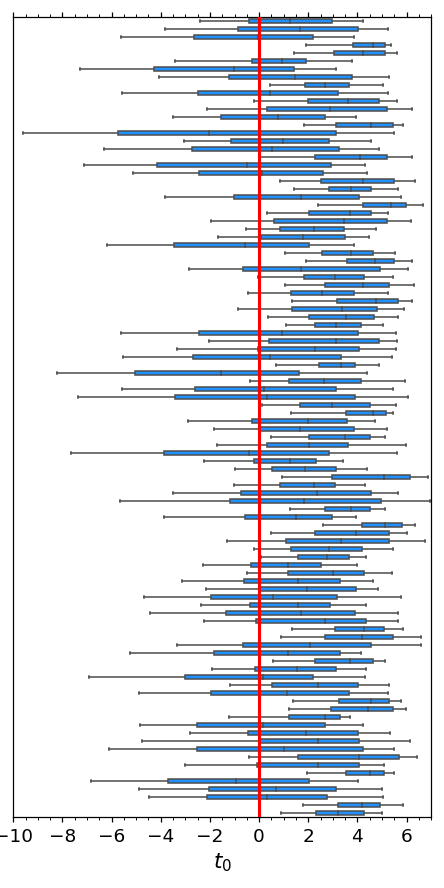

In [42]:
fig, ax = plt.subplots(figsize=(4,8))
bplot = ax.boxplot(t_0_res.T, vert=False, patch_artist=True)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='0.3')
for patch in bplot['boxes']:
        patch.set_facecolor('DodgerBlue')

ax.vlines(0.0, -1e6, 1e6, 
          lw=2, color='red', zorder=10)
ax.tick_params(which='both', left=False, top=True, labelsize=12)
ax.set_yticklabels([])
ax.set_xlabel('$t_0$',fontsize=14)
ax.set_xlim(-10,7)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
fig.subplots_adjust(top=0.98,bottom=0.08, left=0.03, right=0.97)

<IPython.core.display.Javascript object>


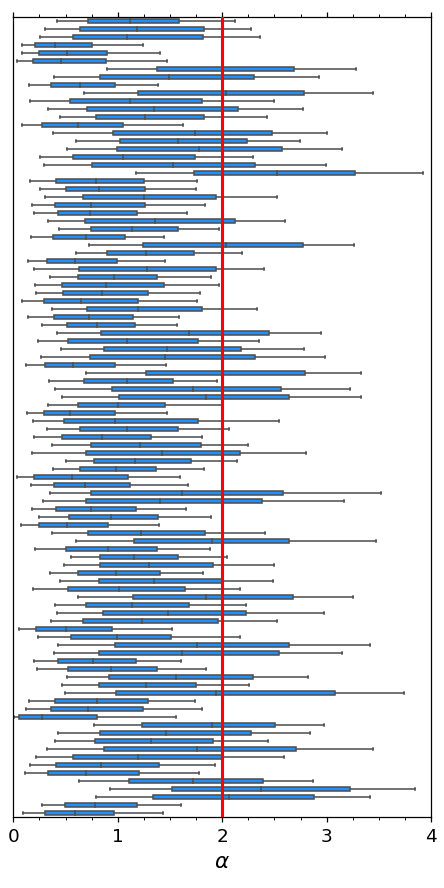

In [48]:
fig, ax = plt.subplots(figsize=(4,8))
bplot = ax.boxplot(alpha_res.T, vert=False, patch_artist=True)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='0.3')
for patch in bplot['boxes']:
        patch.set_facecolor('DodgerBlue')

ax.vlines(2.0, -1e6, 1e6, 
          lw=2, color='red', zorder=10)
ax.tick_params(which='both', left=False, top=True, labelsize=12)
ax.set_yticklabels([])
ax.set_xlabel(r'$\alpha$',fontsize=14)
ax.set_xlim(0,4)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
fig.subplots_adjust(top=0.98,bottom=0.08, left=0.03, right=0.97)

In [ ]:
n_loop = 100
tel_noise = 317

t_start = time.time()
t_det_res = np.zeros(n_loop)
t_0_res = np.zeros((n_loop, 5))
alpha_res = np.zeros((n_loop, 5))
sig_0_res = np.zeros((n_loop, 5))
a_res = np.zeros((n_loop, 5))
b_res = np.zeros((n_loop, 5))

alpha_true = np.zeros(n_loop)
b_true = np.zeros(n_loop)

for loop_num in range(n_loop):
    #Simulate ith light curve
    t_obs = np.arange(-45,18, dtype=float) + np.random.uniform(-1/24,1/24,size=63) + np.random.uniform()
    alpha_sim = np.random.sample()*2 + 0.5
    b_sim = 10**4/(20**alpha_sim)
    alpha_true[loop_num] = alpha_sim
    b_true[loop_num] = b_sim
    
    cnts, cnts_unc = gen_data(t_obs, alpha=alpha_sim, amplitude=b_sim, sigma_sys=tel_noise)

    # light curve to fit
    det = np.where(cnts/cnts_unc >= 4)
    t_data = t_obs[:det[0][0]+4]
    f_data = cnts[:det[0][0]+4]
    f_unc_data = cnts_unc[:det[0][0]+4]

    
    # run MCMC
    #initial guess on parameters
    guess_0 = [0, 10, 0, 2, 10]

    #number of walkers
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=4

    #initial position of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

    #run initial burn-in
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
    nsamples = 2500
    sampler.run_mcmc(pos, nsamples);

    # run second burn in
    burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
    pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    
    # intermediate file to write out data
    filename = "noise{}_loop{}.h5".format(tel_noise, loop_num)
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)

    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), backend=backend)
    nsamples = 5000
    sampler.run_mcmc(pos, nsamples, progress=True);

    # set a "burn-in" limit
    nburn = 3000

    #Grab alpha and t_0 samples from all walkers
    alpha_samples = np.array(sampler.chain[:,:nburn,3]).flatten()
    t_0_samples = np.array(sampler.chain[:,:nburn,2]).flatten()
    a_samples = np.array(sampler.chain[:,:nburn,0]).flatten()
    sig_0_samples = np.array(sampler.chain[:,:nburn,4]).flatten()
    b_samples = np.array(sampler.chain[:,:nburn,1]).flatten()
    #print the median taking 1-sigma confidence intervals
    samples = np.vstack([t_0_samples, alpha_samples, a_samples, b_samples, sig_0_samples]).T
    
    t_0_mc, alpha_mc, a_mc, b_mc, sig_0_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                             zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))


    t_det_res[loop_num] = t_obs[det[0][0]]
    t_0_res[loop_num] = t_0_mc
    alpha_res[loop_num] = alpha_mc
    sig_0_res[loop_num] = sig_0_mc
    a_res[loop_num] = a_mc
    b_res[loop_num] = b_mc
    
t_end = time.time()
print("Serial took {} sec".format(t_end-t_start))

print('\multirow{3}{*}{$\sigma_\mathrm{back} = 317$}' + ' & $t_\mathrm{{{}}}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & $\ldots$ & $\ldots$ \\\\'.format('det', np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 86) - np.percentile(t_det_res, 50),
                                                   np.percentile(t_det_res, 50) - np.percentile(t_det_res, 18)
                                                  ))

for var, input_val in zip(['t_0', 'alpha', 'a', 'b', 'sig_0'], [0, 2, 0, 25, tel_noise]):
    exec(f'res = {var}_res')
    print(' & ${}$ & ${:.2f}\pm^{{{:.2f}}}_{{{:.2f}}}$ & {} & {} \\\\'.format(var, np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 86) - np.percentile(res[:,2], 50),
                                                   np.percentile(res[:,2], 50) - np.percentile(res[:,2], 18),
                                                   len(np.where((res[:,1] < input_val) & (res[:,3] > input_val))[0]),
                                                   len(np.where((res[:,0] < input_val) & (res[:,4] > input_val))[0])
                                                  ))

 12%|█▏        | 591/5000 [00:17<00:51, 86.45it/s]

In [71]:
alpha_true

array([1.1848525 , 0.7329609 , 1.03161482, 1.8406384 , 1.16634555,
       1.66095105, 2.03690389, 0.9473254 , 0.58533158, 1.37947493,
       0.83610407, 2.2198482 , 0.65858175, 1.59454092, 0.83539841,
       0.99918039, 2.49140488, 2.46233435, 2.44653556, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<IPython.core.display.Javascript object>


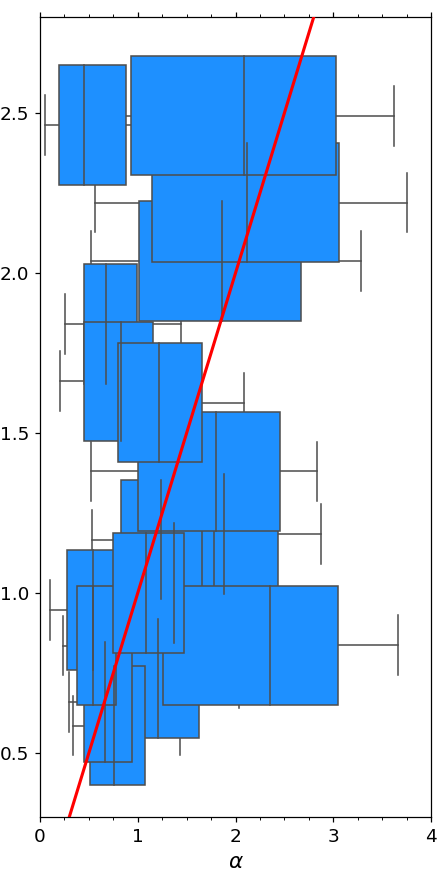

In [78]:
fig, ax = plt.subplots(figsize=(4,8))
bplot = ax.boxplot(alpha_res.T, vert=False, patch_artist=True, positions=alpha_true)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='0.3')
for patch in bplot['boxes']:
        patch.set_facecolor('DodgerBlue')

# ax.vlines(2.0, -1e6, 1e6, 
#           lw=2, color='red', zorder=10)
ax.plot([0,4],[0,4],
          lw=2, color='red', zorder=10)
ax.tick_params(which='both', left=True, top=True, labelsize=12)
ax.set_yticks([0.5,1.0,1.5,2.0,2.5])
ax.set_yticklabels([0.5,1.0,1.5,2.0,2.5])
ax.set_xlabel(r'$\alpha$',fontsize=14)
ax.set_xlim(0,4)
ax.set_ylim(0.3,2.8)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
fig.subplots_adjust(top=0.98,bottom=0.08, left=0.09, right=0.97)

In [4]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames=['a', 'b', 't_0', 'alpha', 'sig_0']